Plan

- Make a pipeline to get the data in to a sql database
- Subset to just the bills introduced in the senate
    - Actions up to the first third reading
- Create the following features
    - Madigan or not
    - chief sponsor
    - number of co sponsors
    - committee it was in
    - perhaps how long something took (intro to second reading)
    - first word in description
    - 

# Put Data In DB

In [64]:
import pandas as pd
import seaborn as sns

In [4]:
bills = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills.csv')

In [9]:
bills = bills.rename(columns={ 'bill_id': 'session_id', 'session_id': 'bill_number', 'bill_number': 'bill_id' })

In [10]:
bills.to_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills_renamed.csv')

In [12]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432/ill_leg', echo=False)

In [13]:
bills.to_sql('bill', con=engine)

In [15]:
history = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/history.csv')
people = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/people.csv')
roll_calls = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/rollcalls.csv')
sponsors = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/sponsors.csv')
votes = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/votes.csv')

In [16]:
for name, df in zip(['history', 'people', 'roll_call', 'sponsor', 'vote'],[history, people, roll_calls, sponsors, votes]):
    df.to_sql(name, con=engine)

# Fetch Data

In [42]:
# Limit to just bills from this year that started in the Senate and got to a second reading
query_bills = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    )
    select * from bill
    where bill_id in (
        select * from started_senate
    ) and bill_id in (
        select * from had_sec_read
    );
"""

bills = pd.read_sql(query_bills, con=engine)

In [43]:
bills = bills.drop(columns=['index'])

# Remove Trivial Resolutions

In [44]:
bills = bills[~bills.last_action.str.contains('Resolution Adopted')]

In [45]:
bills.status_desc.value_counts()

Failed        1194
Passed         526
Vetoed           9
Enrolled         9
Introduced       5
Engrossed        5
Name: status_desc, dtype: int64

In [46]:
526 / (526 + 1194)
# Passing percentage of non-resolution bills that get a second reading

0.3058139534883721

# Explore Failures

In [47]:
bills[bills.status_desc == 'Failed'].last_action.value_counts()
# evertything dies or is vetoed by gov (for the most part)
# only 8 things lost a senate vote (and one of those passed)
# vetoed is also a status (seems inconsistent - perhaps vetoed mean line item veto'd?)
# most of the hanging "introduced" bills had failed votes (4 introduced, 2 engrossed)

Session Sine Die     1161
Total Veto Stands      33
Name: last_action, dtype: int64

In [48]:
bills.status_desc.value_counts()

Failed        1194
Passed         526
Vetoed           9
Enrolled         9
Introduced       5
Engrossed        5
Name: status_desc, dtype: int64

# Pair Plot of Num Co-Sponsors and Dep Var

In [58]:
query_with_features = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    ), num_sponsors as (
    	select b.bill_id, count(s.index) as sponsor_count
    	from bill b
    	join sponsor s on s.bill_id = b.bill_id
    	group by b.bill_id
    )
    select b.*, n.sponsor_count, case when h.index > 0 then true else false end as third_reading_id from bill b
    join num_sponsors n on n.bill_id = b.bill_id
    left join history h on h.bill_id = b.bill_id and h.action ~* 'third reading' and (h.action ~* 'passed' or h.action ~* 'lost')
    where b.bill_id in (
        select * from started_senate
    ) and b.bill_id in (
        select * from had_sec_read
    );
"""

bills_with_features = pd.read_sql(query_with_features, con=engine)

In [62]:
bills_with_features = bills_with_features.drop_duplicates(subset=['bill_id'])

In [63]:
bills_with_features.third_reading_id.value_counts()

True     879
False    869
Name: third_reading_id, dtype: int64

In [66]:
bills_with_features.third_reading_id = bills_with_features.third_reading_id.map(lambda x: 1 if x else 0)

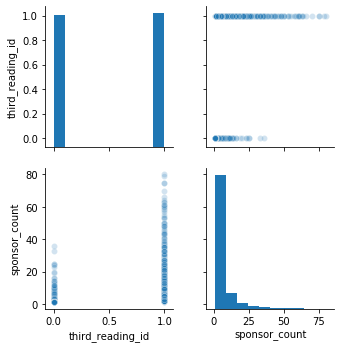

In [68]:
sns.pairplot(bills_with_features[['third_reading_id', 'sponsor_count']], plot_kws={ 'alpha': 0.2})